In [1]:
import sys
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from keras import backend as K
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3 , preprocess_input
from keras.utils import plot_model
from keras.models import load_model
import tensorflow as tf
from tensorflow.python.framework import ops

Using TensorFlow backend.


In [3]:
H, W = 299, 299 # Input shape, defined by the model (model.input_shape)
model_path = r'C:\Users\Kuo Xin\Desktop\MunchAlgo\GoogleML\model4b-Copy1.05-1.27.hdf5'
class_dictionary = np.load('class_indices.npy').item()
num_classes = len(class_dictionary)


In [4]:
# Define model here ---------------------------------------------------
def build_model():
    """Function returning keras model instance.
    
    Model can be
     - Trained here
     - Loaded with load_model
     - Loaded from keras.applications
    """
    return InceptionV3(include_top=True, weights='imagenet')


# ---------------------------------------------------------------------

def load_image(path, preprocess=True):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    return x


def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)


def build_guided_model(loadModel = False, path= None):
    """Function returning modified model.
    
    Changes gradient function for all ReLu activations
    according to Guided Backpropagation.
    """
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.get_default_graph()
    if loadModel == False:
        with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
            return build_model()

    elif loadModel == True:
        with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
            return load_model(path)


def guided_backprop(input_model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val


def grad_cam(input_model, image, cls, layer_name):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0] #y_c is the loss while conv_output is the w.r.t variables
    # Normalize if necessary
    # grads = normalize(grads)

    #Use keras wrapper to create a function which input input_model.input and output conv_output & grads
    gradient_function = K.function([input_model.input], [conv_output, grads]) 

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    #pool the gradients
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights) #larger weights will mean that the features are more important

    # Process CAM
    cam = cv2.resize(cam, (H, W), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

def grad_cam_batch(input_model, images, classes, layer_name):
    """GradCAM method for visualizing input saliency.
    Same as grad_cam but processes multiple images in one run."""
    loss = tf.gather_nd(input_model.output, np.dstack([range(images.shape[0]), classes])[0])
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(loss, layer_output)[0]
    gradient_fn = K.function([input_model.input, K.learning_phase()], [layer_output, grads])

    conv_output, grads_val = gradient_fn([images, 0])    
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.einsum('ijkl,il->ijk', conv_output, weights)
    
    # Process CAMs
    new_cams = np.empty((images.shape[0], H, W))
    for i in range(new_cams.shape[0]):
        cam_i = cams[i] - cams[i].mean()
        cam_i = (cam_i + 1e-10) / (np.linalg.norm(cam_i, 2) + 1e-10)
        new_cams[i] = cv2.resize(cam_i, (H, W), cv2.INTER_LINEAR)
        new_cams[i] = np.maximum(new_cams[i], 0)
        new_cams[i] = new_cams[i] / new_cams[i].max()
    
    return new_cams


def compute_saliency(model, guided_model, img_path, layer_name='mixed10', cls=-1, visualize=True, save=True):
    """Compute saliency using all three approaches.
        -layer_name: layer to compute gradients;
        -cls: class number to localize (-1 for most probable class).
    """
    print("[INFO] loading and preprocessing image...")
    image = load_image(img_path)

    #import pdb;pdb.set_trace()
    #getting the predictions for topNum number 
    topNum = 5
    y_pred_prob = model.predict(image)
    cls = np.argmax(y_pred_prob, axis=1)
    top_n_preds_ix = np.argpartition(y_pred_prob, -topNum)[:,-topNum:]
    
    #convert from ix to class label
    inv_map = {v: k for k, v in class_dictionary.items()}
    label = reversed([inv_map[x] for x in top_n_preds_ix[0]])
    probability = reversed([y_pred_prob[0,x] for x in top_n_preds_ix[0]])

    # get the prediction label
    #print("Predicted Label: {}, Probability: {}".format(label, probability))
    for c, p in zip(label, probability):
        print('\t{:15s}\twith probability {:.5f}'.format(c, p))


#     predictions = model.predict(preprocessed_input)
#     top_n = 5
#     top = decode_predictions(predictions, top=top_n)[0]
#     classes = np.argsort(predictions[0])[-top_n:][::-1]
#     print('Model prediction:')
#     for c, p in zip(classes, top):
#         print('\t{:15s}\t({})\twith probability {:.3f}'.format(p[1], c, p[2]))
#     if cls == -1:
#         cls = np.argmax(predictions)
#     class_name = decode_predictions(np.eye(1, num_classes, cls))[0][0][1]
#     print("Explanation for '{}'".format(class_name))
    
    gradcam = grad_cam(model, image, cls, layer_name)
    gb = guided_backprop(guided_model, image, layer_name)
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if save:
        jetcam = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
        jetcam = (np.float32(jetcam) + load_image(img_path, preprocess=False)) / 2
        cv2.imwrite('gradcam.jpg', np.uint8(jetcam))
        cv2.imwrite('guided_backprop.jpg', deprocess_image(gb[0]))
        cv2.imwrite('guided_gradcam.jpg', deprocess_image(guided_gradcam[0]))
    
    if visualize:
        plt.figure(figsize=(15, 10))
        plt.subplot(131)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(load_image(img_path, preprocess=False))
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(132)
        plt.title('Guided Backprop')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(gb[0]), -1))
        
        plt.subplot(133)
        plt.title('Guided GradCAM')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(guided_gradcam[0]), -1))
        plt.show()
        
    return gradcam, gb, guided_gradcam

def writefile(guided_model):
    with open('layers.txt','w') as file:
        for layer in guided_model.layers:
            file.write(layer.name)
            file.write('\n')    

In [5]:
model = load_model(model_path)
guided_model = build_guided_model(True,model_path)

[INFO] loading and preprocessing image...
	beef don       	with probability 0.99732
	yu sheng       	with probability 0.00030
	tuna sashimi   	with probability 0.00108
	salmon don     	with probability 0.00022
	beef noodles   	with probability 0.00010


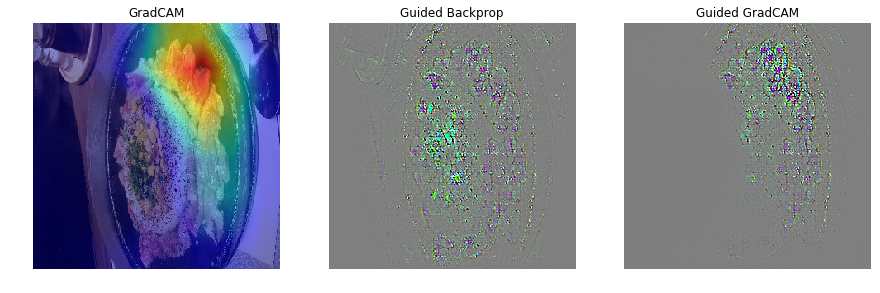

In [6]:
img_path = r'C:\Users\Kuo Xin\Desktop\testing images\20180726_185845.jpg'
gradcam, gb, guided_gradcam = compute_saliency(model, guided_model, layer_name='mixed10',
                                             img_path=img_path, cls=-1, visualize=True, save=False)